In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, Flatten
from sklearn.metrics import mean_absolute_percentage_error
from tqdm import tqdm
import pandas as pd

y_train = np.load('/home/s214626/y_train2.npy')
y_test = np.load('/home/s214626/y_test2.npy')


train_image_features = np.load('/home/s214626/train_features2.npy')
test_image_features = np.load('/home/s214626/test_features2.npy')

trip = pd.read_csv('total_trip_counts.csv')
mean_value = trip['total_trip_count'].mean()
print(mean_value)

2023-06-18 19:22:33.345746: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-18 19:22:33.394215: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-18 19:22:33.395042: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 19:22:34.282605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


1083.683959513155


In [2]:
# Reshape the input features
train_image_features_2d = train_image_features.reshape(train_image_features.shape[0], -1)
test_image_features_2d = test_image_features.reshape(test_image_features.shape[0], -1)

# Build the model
input_shape = (train_image_features_2d.shape[1],)
image_input = Input(shape=input_shape, name='image_input')
hidden_layer = Dense(64, activation='relu')(image_input)
output = Dense(1, activation='linear')(hidden_layer)
model = Model(inputs=image_input, outputs=output)

# Define custom MAPE loss function
def mape_loss(y_true, y_pred):
    diff = tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true), 1e-8, np.inf))
    return tf.reduce_mean(diff)

# Compile the model with MAPE loss
model.compile(loss=mape_loss, optimizer='adam')

# Define callbacks to calculate test loss after each epoch
class TestLossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss = self.model.evaluate(test_image_features_2d, y_test, verbose=0)
        #print(f'Test Loss after epoch {epoch + 1}: {test_loss:.4f}')

# Train the model
history = model.fit(train_image_features_2d, y_train, epochs=10, batch_size=32, verbose=1,
                    validation_data=(test_image_features_2d, y_test), callbacks=[TestLossCallback()])

# Evaluate the model using MAPE
model_predictions = model.predict(test_image_features_2d)


model_loss = mean_absolute_percentage_error(y_test, model_predictions)

# Print the final test loss
print("Final Test Loss:", model_loss)



2023-06-14 18:43:35.533901: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2777241600 exceeds 10% of free system memory.


Epoch 1/10
346/346 [==============================] - 6s 15ms/step - loss: 0.8862 - val_loss: 0.8711
Epoch 2/10
346/346 [==============================] - 5s 14ms/step - loss: 0.8530 - val_loss: 0.8612
Epoch 3/10
346/346 [==============================] - 5s 14ms/step - loss: 0.8378 - val_loss: 0.8657
Epoch 4/10
346/346 [==============================] - 5s 14ms/step - loss: 0.8225 - val_loss: 0.8613
Epoch 5/10
346/346 [==============================] - 5s 14ms/step - loss: 0.8116 - val_loss: 0.8669
Epoch 6/10
346/346 [==============================] - 5s 14ms/step - loss: 0.7994 - val_loss: 0.8602
Epoch 7/10
346/346 [==============================] - 5s 14ms/step - loss: 0.7880 - val_loss: 0.8666
Epoch 8/10
346/346 [==============================] - 5s 14ms/step - loss: 0.7740 - val_loss: 0.8558
Epoch 9/10
346/346 [==============================] - 5s 14ms/step - loss: 0.7572 - val_loss: 0.8646
Epoch 10/10
87/87 [==============================] - 0s 2ms/step
Final Test Loss: 0.8574723

In [3]:
import pandas as pd
# Convert the predictions to a dataframe
predictions_df = pd.DataFrame(model_predictions, columns=['predictions'])

# Save the predictions to a CSV file
predictions_df.to_csv('predictions2.csv', index=False)

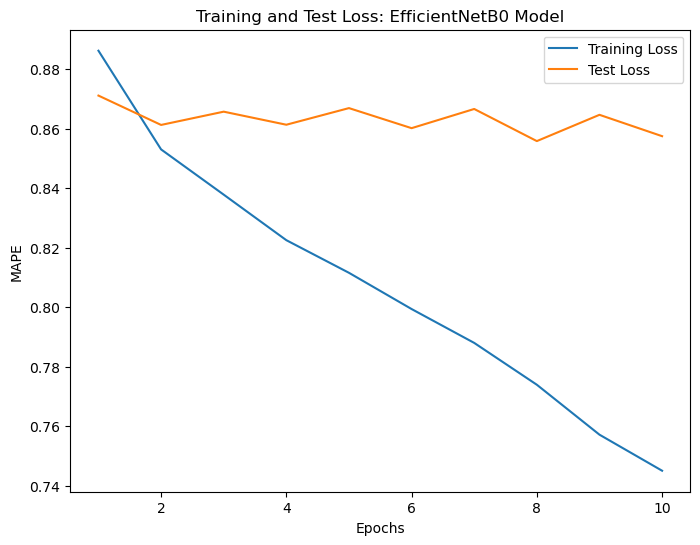

In [4]:
# Plot the loss of the model
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.title('Training and Test Loss: EfficientNetB0 Model')
plt.legend()
plt.show()


In [5]:
# Find the highest and lowest total trip count values
max_trip_count = y_train.max()
min_trip_count = y_train.min()

print("Highest Total Trip Count:", max_trip_count)
print("Lowest Total Trip Count:", min_trip_count)

Highest Total Trip Count: 11150.0
Lowest Total Trip Count: 5.0


In [6]:
max_trip_count = model_predictions.max()
print(max_trip_count )

529.0992


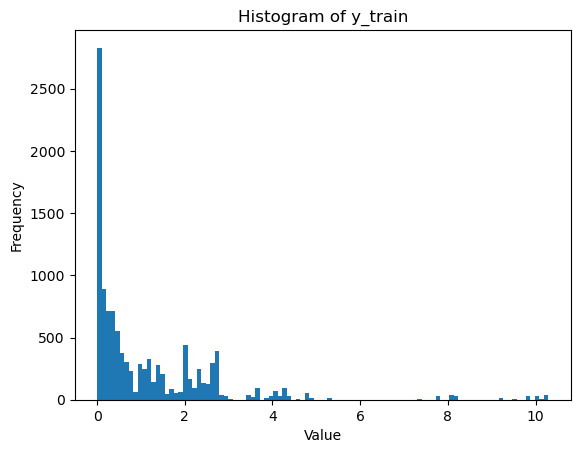

In [7]:
import matplotlib.pyplot as plt

# Plot histogram
plt.hist(y_train/mean_value, bins=100)  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of y_train')
plt.show()


In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from shapely.wkt import loads
from sklearn.model_selection import train_test_split

# Load the CSV data
data = pd.read_csv('final_data.csv')
# Preprocess the data

# Filter out rows with missing image paths
data = data.dropna(subset=['image_path'])
print(data.shape)
# Create a bounding box
bbox = box(12.530883, 55.740750,  12.549771, 55.755021)

# Convert the geometry strings to Point objects
data['geometry'] = data['geometry'].apply(lambda x: loads(x))

# Convert the data to a GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry='geometry')

# Filter out data outside the bounding box
data = gdf[gdf.geometry.within(bbox)]
print(data.shape)

# Split the dataset into training and testing sets
X = data['image_path']
y = data['total_trip_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Define file paths for saving the features

(581102, 7)
(13838, 7)


In [9]:
print(data)

               image_id                   geometry  index_right      edgeUID  \
555040  369809927743665  POINT (12.54330 55.75341)     214060.0  174596982.0   
555041  815737132672220  POINT (12.54393 55.75469)       8997.0  174597053.0   
555042  815737132672220  POINT (12.54393 55.75469)      47982.0  174597055.0   
555043  815737132672220  POINT (12.54393 55.75469)     263607.0  174597041.0   
555044  459764655333477  POINT (12.53275 55.75430)     152519.0  174596604.0   
...                 ...                        ...          ...          ...   
581054  864235920824186  POINT (12.54818 55.74363)     238684.0  174595813.0   
581065  472756350700491  POINT (12.54859 55.74268)     181256.0  174595807.0   
581067  419304572563104  POINT (12.54943 55.74153)      16037.0  174595788.0   
581083  372315224056931  POINT (12.54668 55.74632)      70533.0  174597968.0   
581089  988716201866633  POINT (12.54966 55.75061)     272287.0  174598262.0   

              osmId                    

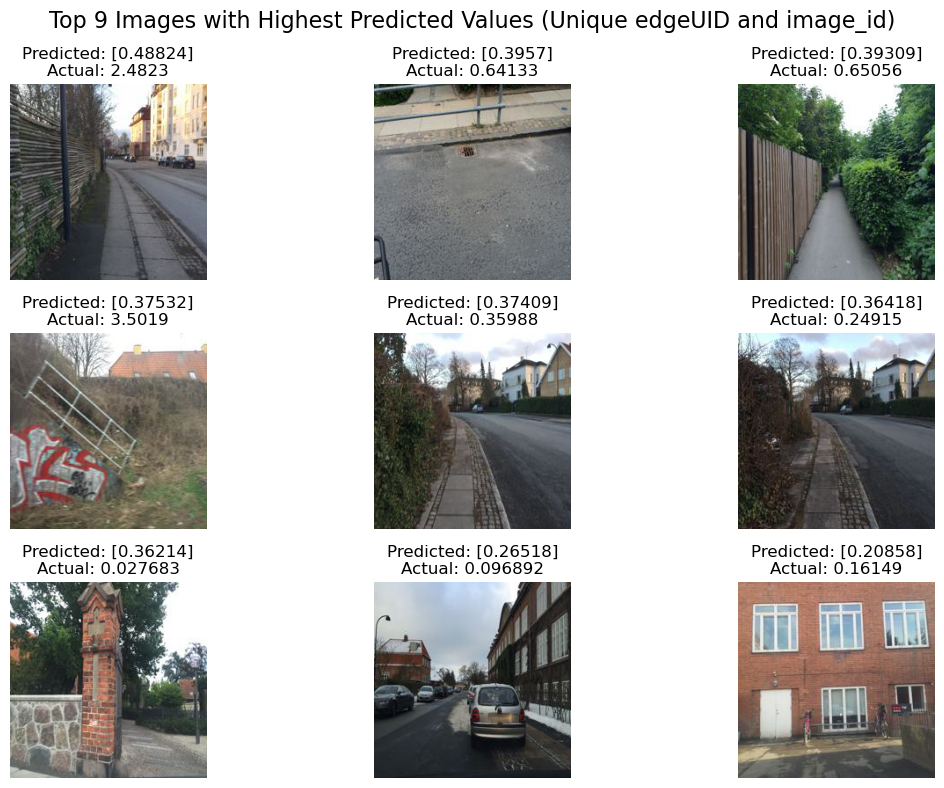

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Get the indices of the top 50 highest predictions
top_indices = np.argsort(model_predictions.flatten())[::-1][:100]

# Create a set to store unique combinations of edgeUID and image_id
unique_combinations = set()
unique_image = set()
unique_edge = set()

# Plot the top 9 images with highest predicted values from different edgeUID and image_id
plt.figure(figsize=(12, 8))
subplot_index = 1
for index in top_indices:
    i= data[(data['image_path'] == X_test.iloc[index]) & (data['total_trip_count'] == y_test.iloc[index])].index[0]
    image_path = X_test.iloc[index]
    if image_path not in unique_image:
        unique_image.add(image_path)
        edge_id= data.loc[i, 'edgeUID']
        if edge_id not in unique_edge:
            unique_edge.add(edge_id)
            combination = (edge_id, image_path)
            unique_combinations.add(combination)

            predicted_value = model_predictions[index]
            actual_value = y_test.iloc[index]
            image = plt.imread(image_path)

            plt.subplot(3, 3, subplot_index)
            plt.imshow(image)
            np.set_printoptions(precision=5, suppress=True)
            plt.title(f"Predicted: {predicted_value/mean_value}\nActual: {'{:.5g}'.format(actual_value/mean_value)}")
            plt.axis('off')

            subplot_index += 1

    if len(unique_combinations) == 9:
        break
plt.suptitle("Top 9 Images with Highest Predicted Values (Unique edgeUID and image_id)", fontsize=16)
plt.tight_layout()
plt.show()


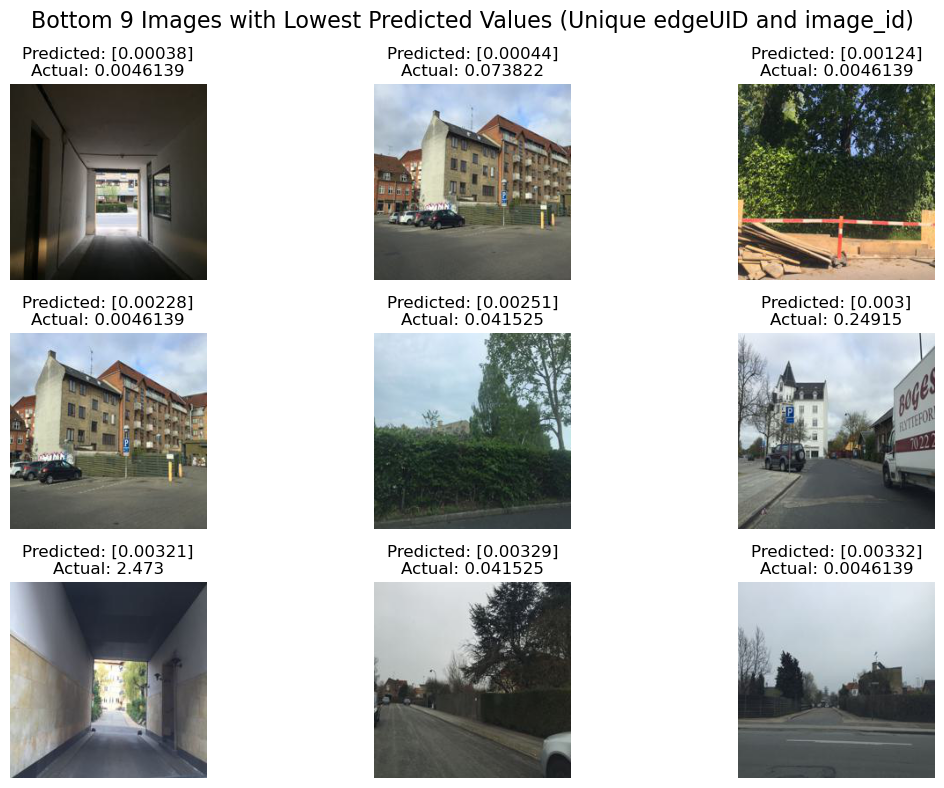

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Get the indices of the bottom 50 predictions
bottom_indices = np.argsort(model_predictions.flatten())[:50]

# Create a set to store unique combinations of edgeUID and image_id
unique_combinations = set()
unique_image = set()
unique_edge = set()

# Plot the bottom 9 images with highest predicted values from different edgeUID and image_id
plt.figure(figsize=(12, 8))
subplot_index = 1
for index in bottom_indices:
    i= data[(data['image_path'] == X_test.iloc[index]) & (data['total_trip_count'] == y_test.iloc[index])].index[0]
    image_path = X_test.iloc[index]
    if image_path not in unique_image:
        unique_image.add(image_path)
        edge_id= data.loc[i, 'edgeUID']
        if edge_id not in unique_edge:
            unique_edge.add(edge_id)
            combination = (edge_id, image_path)
            unique_combinations.add(combination)

            predicted_value = model_predictions[index]
            actual_value = y_test.iloc[index]
            image = plt.imread(image_path)

            plt.subplot(3, 3, subplot_index)
            plt.imshow(image)
            np.set_printoptions(precision=5, suppress=True)
            plt.title(f"Predicted: {predicted_value/mean_value}\nActual: {'{:.5g}'.format(actual_value/mean_value)}")
            plt.axis('off')

            subplot_index += 1

    if len(unique_combinations) == 9:
        break

plt.suptitle("Bottom 9 Images with Lowest Predicted Values (Unique edgeUID and image_id)", fontsize=16)
plt.tight_layout()
plt.show()


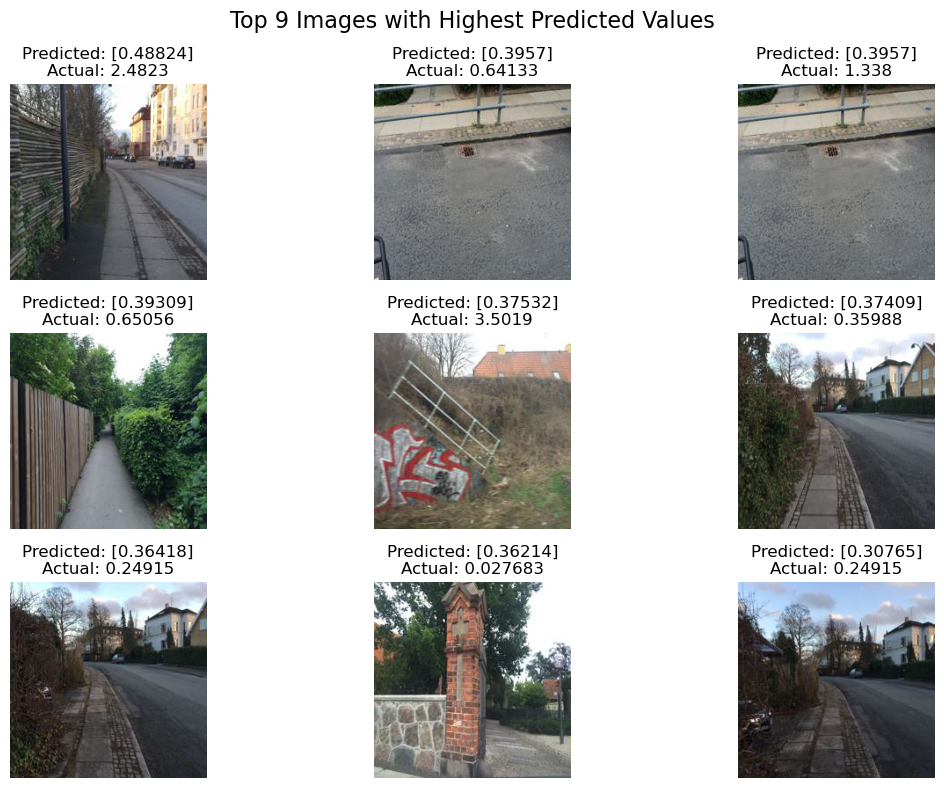

In [14]:
# Get the indices of the top 9 highest predictions
top_indices = np.argsort(model_predictions.flatten())[::-1][:9]

# Plot the top 9 images with highest predicted values
plt.figure(figsize=(12, 8))
for i, index in enumerate(top_indices):
    image_path = X_test.iloc[index]
    predicted_value = model_predictions[index]
    actual_value = y_test.iloc[index]
    image = plt.imread(image_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    np.set_printoptions(precision=5, suppress=True)
    plt.title(f"Predicted: {predicted_value/mean_value}\nActual: {'{:.5g}'.format(actual_value/mean_value)}")
    plt.axis('off')
plt.suptitle("Top 9 Images with Highest Predicted Values", fontsize=16)
plt.tight_layout()
plt.show()


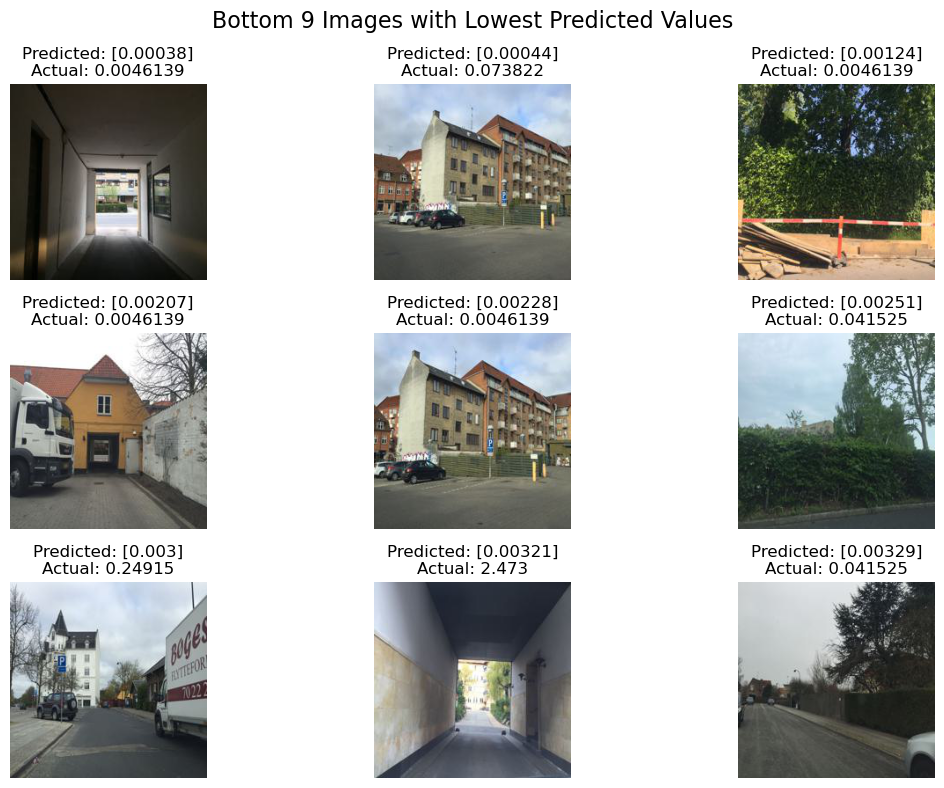

In [15]:
# Get the indices of the bottom 9 lowest predictions
bottom_indices = np.argsort(model_predictions.flatten())[:9]

# Plot the bottom 9 images with lowest predicted values
plt.figure(figsize=(12, 8))
for i, index in enumerate(bottom_indices):
    image_path = X_test.iloc[index]
    predicted_value = model_predictions[index]
    actual_value = y_test.iloc[index]
    image = plt.imread(image_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    np.set_printoptions(precision=5, suppress=True)
    plt.title(f"Predicted: {predicted_value/mean_value}\nActual: {'{:.5g}'.format(actual_value/mean_value)}")
    plt.axis('off')
plt.suptitle("Bottom 9 Images with Lowest Predicted Values", fontsize=16)
plt.tight_layout()
plt.show()


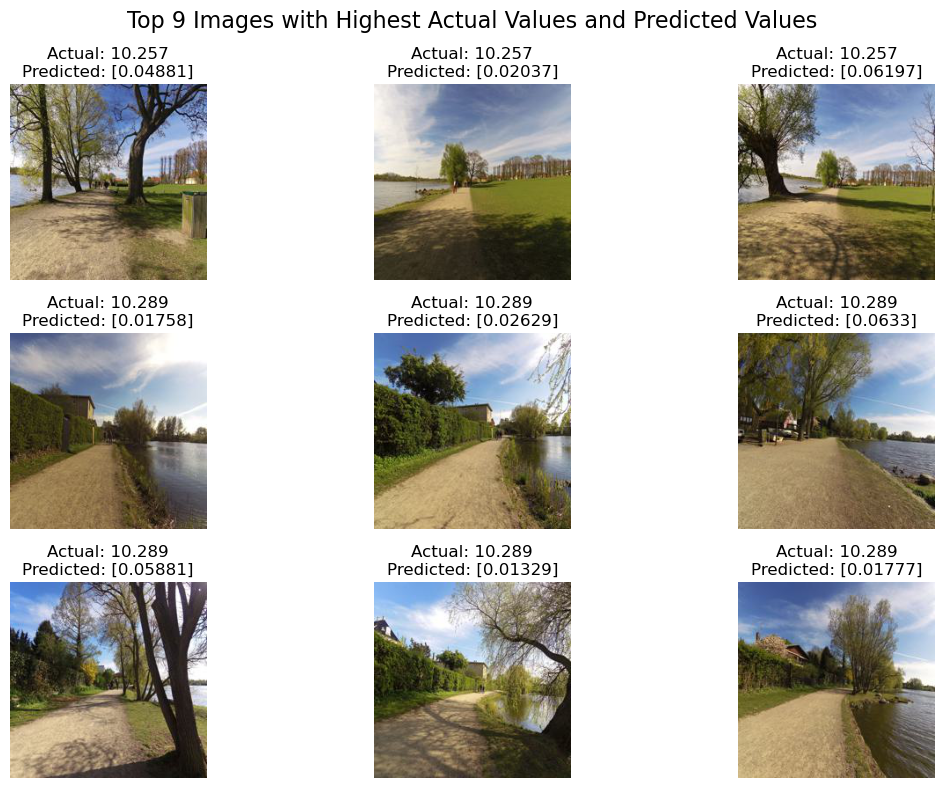

In [16]:
# Get the indices of the top 9 highest actual values
top_indices = np.argsort(y_test)[-9:]

# Plot the top 9 images with highest actual values and their predicted values
plt.figure(figsize=(12, 8))
for i, index in enumerate(top_indices):
    image_path = X_test.iloc[index]
    actual_value = y_test.iloc[index]
    predicted_value = model_predictions[index]
    image = plt.imread(image_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    np.set_printoptions(precision=5, suppress=True)
    plt.title(f"Actual: {'{:.5g}'.format(actual_value/mean_value)}\nPredicted: {predicted_value/mean_value}")
    plt.axis('off')
plt.suptitle("Top 9 Images with Highest Actual Values and Predicted Values", fontsize=16)
plt.tight_layout()
plt.show()


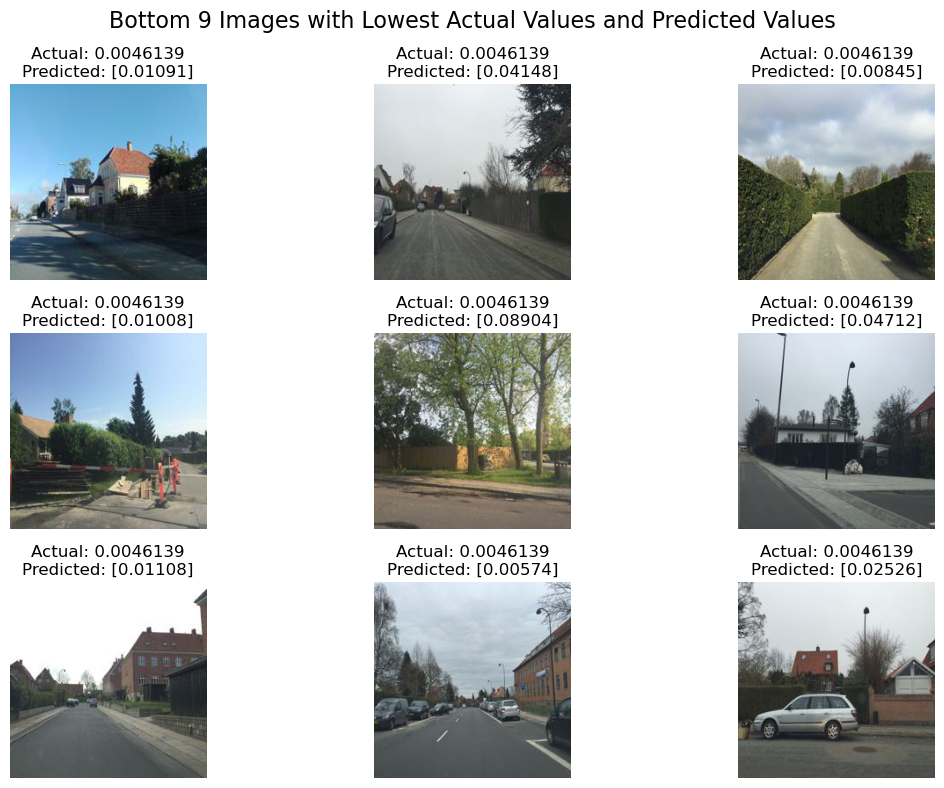

In [17]:
# Get the indices of the bottom 9 lowest actual values
bottom_indices = np.argsort(y_test)[:9]

# Plot the bottom 9 images with lowest actual values and their predicted values
plt.figure(figsize=(12, 8))
for i, index in enumerate(bottom_indices):
    image_path = X_test.iloc[index]
    actual_value = y_test.iloc[index]
    predicted_value = model_predictions[index]
    image = plt.imread(image_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    np.set_printoptions(precision=5, suppress=True)
    plt.title(f"Actual: {'{:.5g}'.format(actual_value/mean_value)}\nPredicted: {predicted_value/mean_value}")
    plt.axis('off')
plt.suptitle("Bottom 9 Images with Lowest Actual Values and Predicted Values", fontsize=16)
plt.tight_layout()
plt.show()


In [3]:
print(train_image_features)

[[-0.16218908 -0.20544165 -0.14841771 ...  0.6533522  -0.24947031
  -0.27356175]
 [-0.27818197 -0.23478517 -0.23750669 ... -0.26769936 -0.17871901
  -0.23685592]
 [-0.2779224  -0.0103778  -0.11286942 ... -0.05495229 -0.01345177
  -0.2679783 ]
 ...
 [-0.27782714 -0.10862037 -0.27846414 ... -0.17654665 -0.15809046
  -0.11657542]
 [-0.11875619 -0.08990701 -0.11198734 ...  0.42983988 -0.27182478
  -0.24900952]
 [-0.2756355  -0.04856519 -0.0981045  ...  1.6182305  -0.20911083
  -0.27249545]]


In [56]:
a=train_image_features[87]
print(a.max())
print(a.min())
np.var(a)

14.983657
-0.27846456


0.7718902

In [3]:
print(np.shape(test_image_features))

from sklearn.cluster import KMeans

(2768, 62720)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume matrix has shape of (XXX, 62720)
#scaler = StandardScaler().set_output(transform="pandas")
#test_image_features_scaled = scaler.fit_transform(test_image_features)

matrix = np.array(test_image_features)

# Apply PCA to calculate variance explained
pca = PCA()
matrix_pca = pca.fit_transform(matrix)

# Get the cumulative sum of explained variance ratios
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components needed for 95% variance explained
n_components = np.argmax(cumulative_variance >= 0.95) + 1

print(n_components)

1544


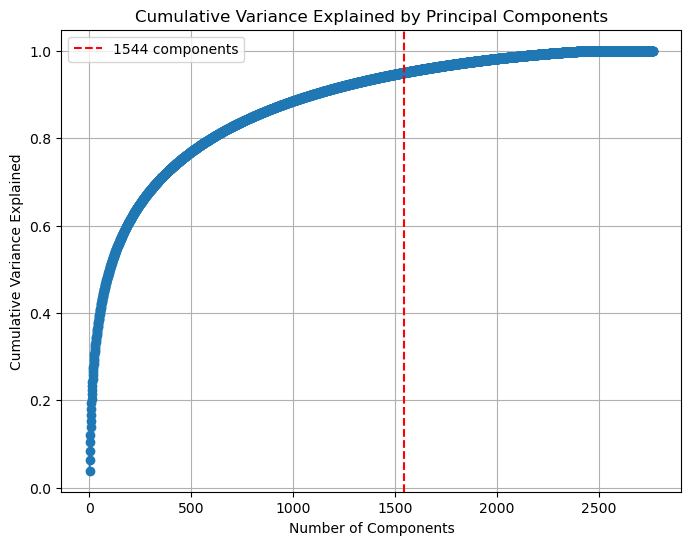

In [5]:
# Create a bar plot of the explained variance ratios
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axvline(x=n_components, color='red', linestyle='--', label=f'{n_components} components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
print(np.shape(matrix_pca))

(2768, 2768)


In [7]:
# Reduce the original PCA matrix to the components that explain 95% of the variance
matrix_pca = matrix_pca[:, :n_components+1]

print(np.shape(matrix_pca))

(2768, 1545)


In [8]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

#Cluster number optimization
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(matrix_pca)
    kmeanModel.fit(matrix_pca)
 
    distortions.append(sum(np.min(cdist(matrix_pca, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / matrix_pca.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(matrix_pca, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / matrix_pca.shape[0]
    mapping2[k] = kmeanModel.inertia_

/opt/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/

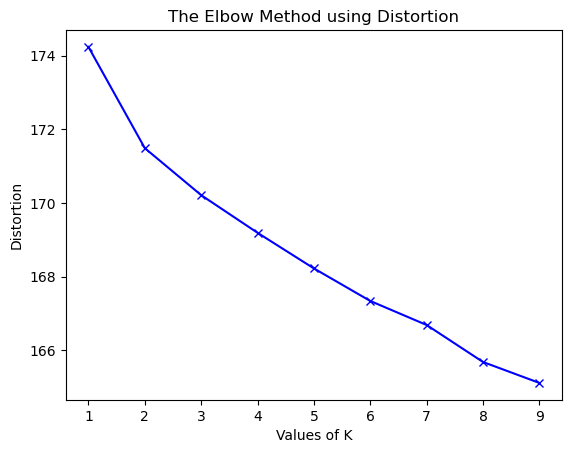

In [9]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

/opt/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/mpl_toolkits/mplot3d/art3d.py:1104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/opt/anaconda3/lib/python3.10/site-packages/mpl_toolkits/mplot3d/art3d.py:1106: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


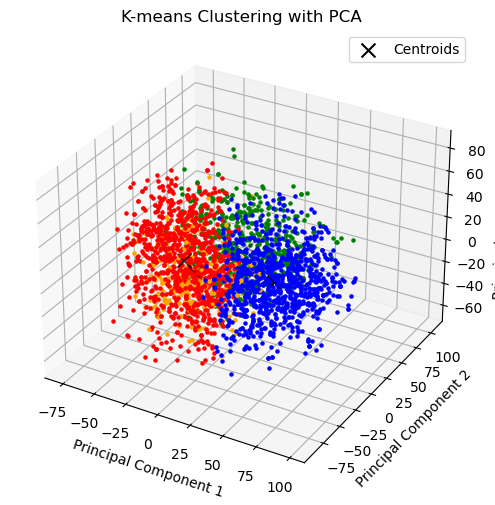

In [10]:
# Perform K-means clustering on the PCA-transformed data
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(matrix_pca)

# Get the coordinates of the cluster centroids
centroids = kmeans.cluster_centers_

# Create a 3D scatter plot for visualization
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot each point with its corresponding cluster color
for i in range(len(matrix_pca)):
    if clusters[i] == 0:
        ax.scatter(matrix_pca[i, 0], matrix_pca[i, 1], matrix_pca[i, 2], color='red', marker='.')
    elif clusters[i] == 1:
        ax.scatter(matrix_pca[i, 0], matrix_pca[i, 1], matrix_pca[i, 2], color='blue', marker='.')
    elif clusters[i] == 2:
        ax.scatter(matrix_pca[i, 0], matrix_pca[i, 1], matrix_pca[i, 2], color='green', marker='.')
    elif clusters[i] == 3:
        ax.scatter(matrix_pca[i, 0], matrix_pca[i, 1], matrix_pca[i, 2], color='orange', marker='.')

# Plot the cluster centroids
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], centroids[:, 3], color='black', marker='x', s=100, label='Centroids')

ax.set_title('K-means Clustering with PCA')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

In [11]:
#The image indexes in the specific clusters

cluster1_images = []
cluster2_images = []
cluster3_images = []
cluster4_images = []
for i in range(len(clusters)):
    if clusters[i] == 0:
        cluster1_images.append(i)
    elif clusters[i] == 1:
        cluster2_images.append(i)
    elif clusters[i] == 2:
        cluster3_images.append(i)
    elif clusters[i] == 3:
        cluster4_images.append(i)

#The image paths for cluster 1
cluster1_imagepath = []
for i in cluster1_images:
#    if i in X_train:
    cluster1_imagepath.append(X_test.iloc[i])

#The image paths for cluster 2
cluster2_imagepath = []
for i in cluster2_images:
#    if i in X_train:
    cluster2_imagepath.append(X_test.iloc[i])

#The image paths for cluster 3
cluster3_imagepath = []
for i in cluster3_images:
#    if i in X_train:
    cluster3_imagepath.append(X_test.iloc[i])
    

#The image paths for cluster 4
cluster4_imagepath = []
for i in cluster4_images:
#    if i in X_train:
    cluster4_imagepath.append(X_test.iloc[i])

print(len(cluster1_imagepath), len(cluster2_imagepath), len(cluster3_imagepath), len(cluster4_imagepath))


981 937 534 316


img = plt.imread(cluster1_imagepath[1])
plt.imshow(img)

In [12]:
print(y_test)

574954      190.0
571059      170.0
559168      510.0
559826      520.0
556639     2840.0
           ...   
571669     1075.0
564992       15.0
563956    10920.0
563014      240.0
561979     2825.0
Name: total_trip_count, Length: 2768, dtype: float64


In [13]:
# Load the CSV file into a DataFrame
df = pd.read_csv('predictions2.csv')

In [14]:
print(df)

      predictions
0      156.102330
1       17.519754
2       53.872368
3       34.826300
4       12.722726
...           ...
2763    74.192360
2764    30.311777
2765    26.913605
2766    40.708755
2767    47.114640

[2768 rows x 1 columns]


In [15]:
# Convert y-test and y-predict to numpy arrays for easier manipulation
y_test = np.array(y_test)
y_predict = np.array(df['predictions'].values) # Replace the ellipsis with the complete y-predict values

# Extract the corresponding values from y-test and y-predict using the indices
y_test_subset = y_test[cluster1_images]
y_predict_subset = y_predict[cluster1_images]

# Calculate the MAPE using the scikit-learn function
mape = mean_absolute_percentage_error(y_test_subset, y_predict_subset)

print("MAPE:", mape)
print("mean:", np.mean(y_test_subset))
print("mean pred:", np.mean(y_predict_subset))

MAPE: 0.9206372043280104
mean: 1359.2252803261977
mean pred: 64.41507926216106


In [14]:
# Convert y-test and y-predict to numpy arrays for easier manipulation
y_test = np.array(y_test)
y_predict = np.array(df['predictions'].values) # Replace the ellipsis with the complete y-predict values

# Extract the corresponding values from y-test and y-predict using the indices
y_test_subset = y_test[cluster2_images]
y_predict_subset = y_predict[cluster2_images]

# Calculate the MAPE using the scikit-learn function
mape = mean_absolute_percentage_error(y_test_subset, y_predict_subset)

print("MAPE:", mape)
print("mean:", np.mean(y_test_subset))
print("mean pred:", np.mean(y_predict_subset))

MAPE: 0.8211823103293221
mean: 1256.2700106723587
mean pred: 49.081461721344716


In [15]:
# Convert y-test and y-predict to numpy arrays for easier manipulation
y_test = np.array(y_test)
y_predict = np.array(df['predictions'].values) # Replace the ellipsis with the complete y-predict values

# Extract the corresponding values from y-test and y-predict using the indices
y_test_subset = y_test[cluster3_images]
y_predict_subset = y_predict[cluster3_images]

# Calculate the MAPE using the scikit-learn function
mape = mean_absolute_percentage_error(y_test_subset, y_predict_subset)

print("MAPE:", mape)
print("mean:", np.mean(y_test_subset))
print("mean pred:", np.mean(y_predict_subset))

MAPE: 0.8474458884114568
mean: 920.7022471910112
mean pred: 39.70317635655431


In [16]:
# Convert y-test and y-predict to numpy arrays for easier manipulation
y_test = np.array(y_test)
y_predict = np.array(df['predictions'].values) # Replace the ellipsis with the complete y-predict values

# Extract the corresponding values from y-test and y-predict using the indices
y_test_subset = y_test[cluster4_images]
y_predict_subset = y_predict[cluster4_images]

# Calculate the MAPE using the scikit-learn function
mape = mean_absolute_percentage_error(y_test_subset, y_predict_subset)

print("MAPE:", mape)
print("mean:", np.mean(y_test_subset))
print("mean pred:", np.mean(y_predict_subset))

MAPE: 0.7859316134320473
mean: 895.4272151898734
mean pred: 61.5183038136076


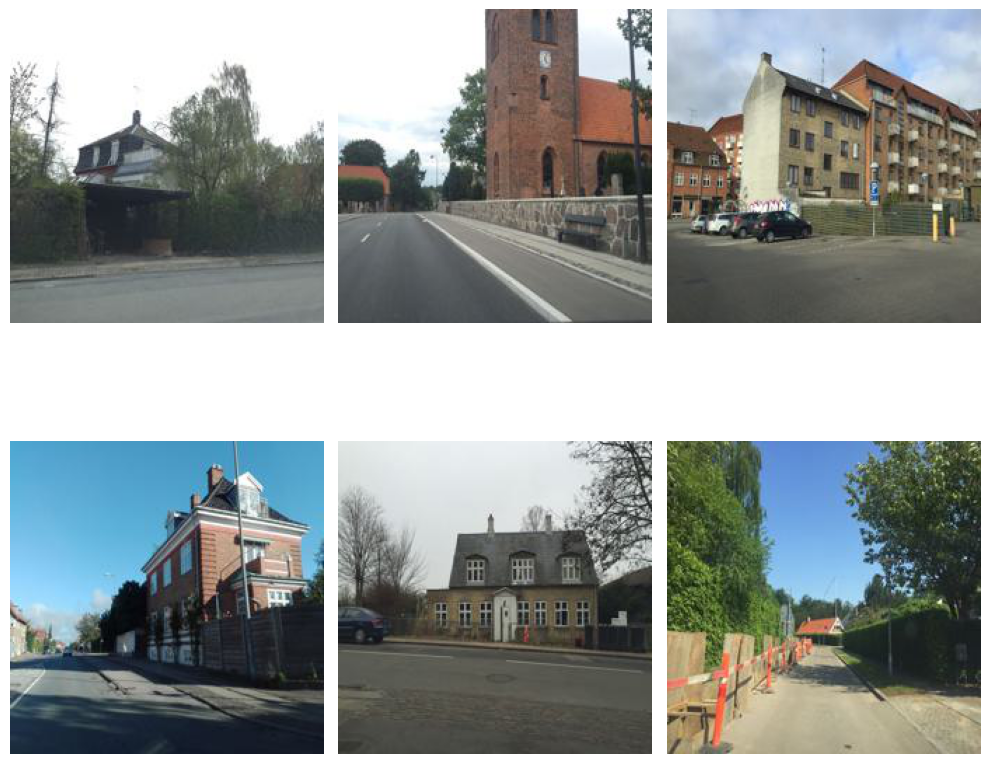

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Randomly select 9 image paths from cluster2_imagepath
random_image_paths = random.sample(cluster1_imagepath, 6)

# Plot the images
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
axes = axes.flatten()

for i, image_path in enumerate(random_image_paths):
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

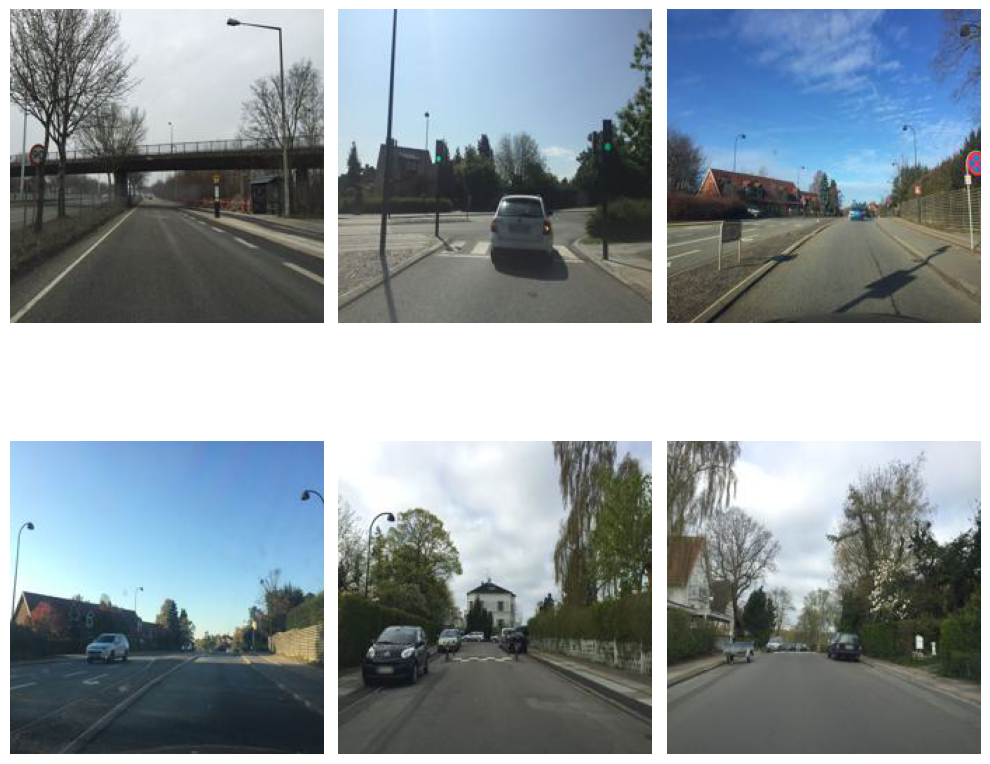

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Randomly select 9 image paths from cluster2_imagepath
random_image_paths = random.sample(cluster2_imagepath, 6)
# Plot the images
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
axes = axes.flatten()

for i, image_path in enumerate(random_image_paths):
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()



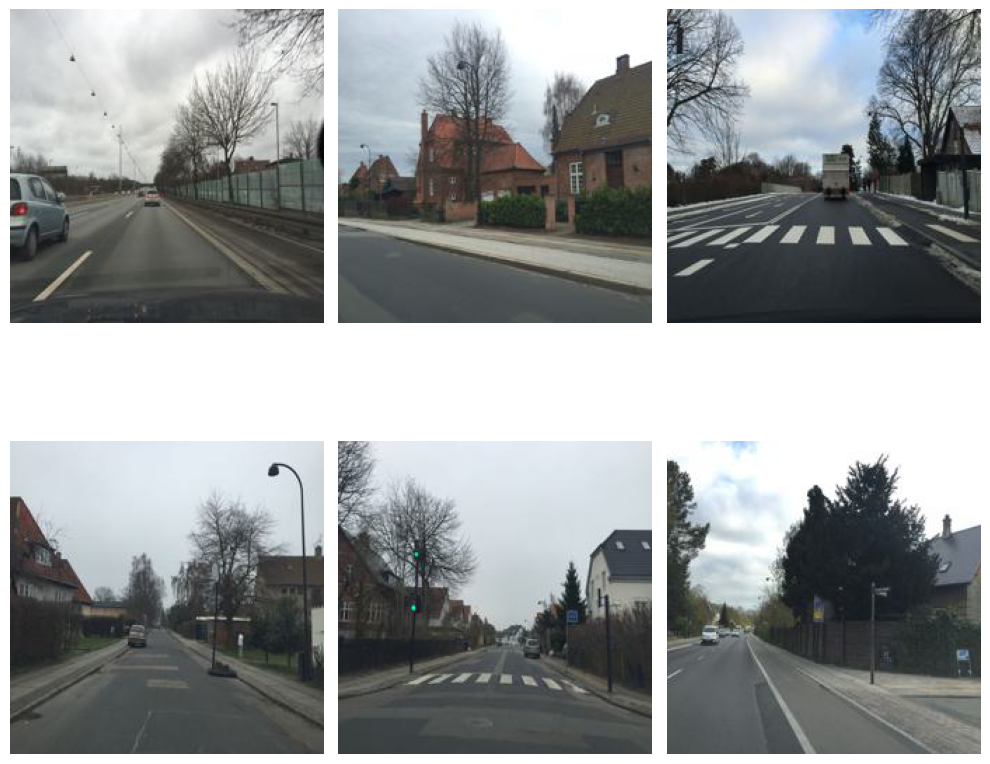

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Randomly select 9 image paths from cluster2_imagepath
random_image_paths = cluster3_imagepath[10:16]

# Plot the images
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
axes = axes.flatten()

for i, image_path in enumerate(random_image_paths):
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

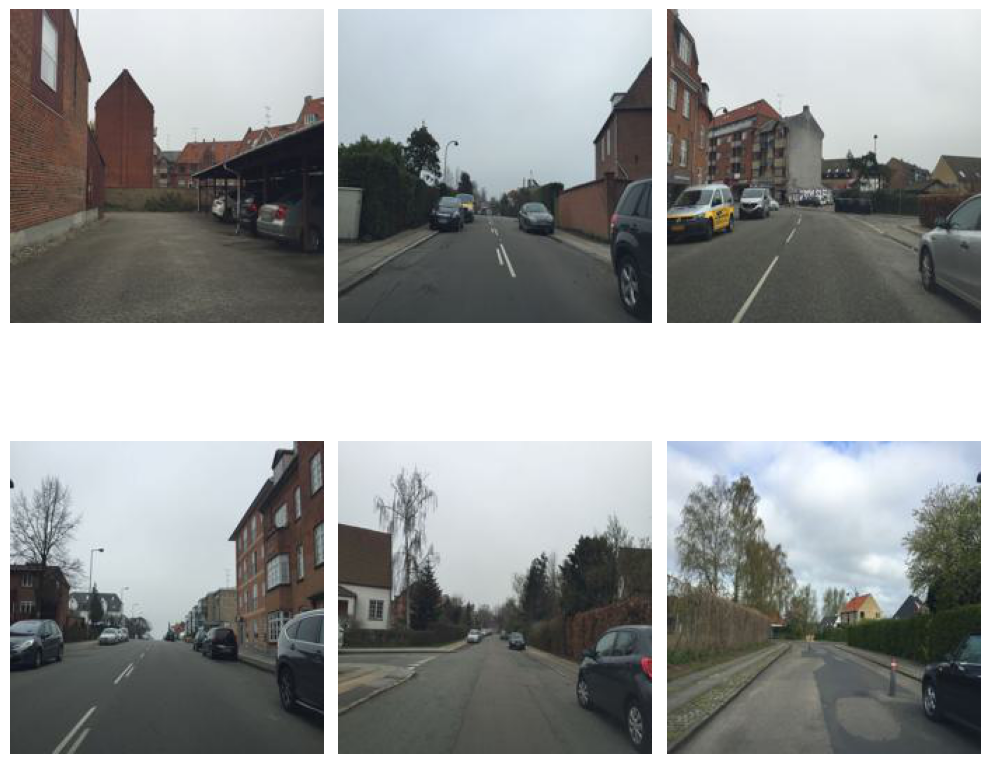

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Randomly select 9 image paths from cluster2_imagepath
random_image_paths = random.sample(cluster4_imagepath, 6)

# Plot the images
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
axes = axes.flatten()

for i, image_path in enumerate(random_image_paths):
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [16]:
y_tests = y_test/np.mean(y_test)
y_predict = np.array(df['predictions'].values) # Replace the ellipsis with the complete y-predict values

y_mean1 = np.mean(y_tests[cluster1_images])
y_mean2 = np.mean(y_tests[cluster2_images])
y_mean3 = np.mean(y_tests[cluster3_images])
y_mean4 = np.mean(y_tests[cluster4_images])

print(y_mean1)
print(y_mean2)
print(y_mean3)
print(y_mean4)

1.1452605679653698
1.058512173637031
0.7757683687960217
0.7544720480727791


In [30]:
from scipy.stats import levene

# Perform Levene's test for homoscedasticity
levene_statistic, p_value = levene(y_tests[cluster1_images], y_tests[cluster2_images], y_tests[cluster3_images], y_tests[cluster4_images])

print("Levene's statistic:", levene_statistic)
print("p-value:", p_value)

Levene's statistic: 14.726393530011652
p-value: 1.6338342769882422e-09


In [20]:
from scipy import stats
import numpy as np

# Perform Wilcoxon rank-sum test
u_statistic, p_value = stats.mannwhitneyu(y_tests[cluster1_images], y_tests[cluster4_images])

print("Mann-Whitney U statistic:", u_statistic)
print("p-value:", p_value)

Mann-Whitney U statistic: 157874.5
p-value: 0.6194014046659803
